In [1]:
from model import *
from data import *

from importlib import reload  # Python 3.4+ only.
import data
import model as model_functions

reload(data)
reload(model_functions)

Using TensorFlow backend.


<module 'model' from 'D:\\drive\\MyDriveBackup\\9.Semester\\Masterarbeit\\masterarbeit - git\\U-Net\\model.py'>

In [2]:
WIDTH = 256
HEIGHT = 256

combined_folds_dir = "k-folds/combined folds"


In [3]:
BATCH_SIZE = 7

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    vertical_flip=True,
                    brightness_range=[0.2,1.8],
                    #validation_split = 0.3,
                    fill_mode="reflect")

def get_generators(train_dir="../../Data/Masked Images/k-folds/combined folds/0/train", val_dir="../../Data/Masked Images/k-folds/combined folds/0/validate"):
    myGene = trainGenerator(BATCH_SIZE
                     ,train_dir
                     ,'image'
                     #,'label'
                     ,'multi-label'
                     ,data_gen_args
                     ,image_color_mode='rgb'
                     ,mask_color_mode='rgb'
                     ,target_size=(WIDTH,HEIGHT)
                     ,save_to_dir = None
                     ,flag_multi_class = True
                     ,num_class = 3
                     ,preprocessing_function=custom_preprocess_input
                       )

    myGeneValidate = trainGenerator(BATCH_SIZE
                     ,val_dir
                     ,'image'
                     #,'label'
                     ,'multi-label'
                     ,data_gen_args
                     ,image_color_mode='rgb'
                     ,mask_color_mode='rgb'
                     ,target_size=(WIDTH,HEIGHT)
                     ,save_to_dir = None
                     ,flag_multi_class = True
                     ,num_class = 3
                     ,preprocessing_function=custom_preprocess_input
                               )
    
    return myGene, myGeneValidate

In [4]:
from keras.applications.densenet import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(HEIGHT,WIDTH,3))

In [5]:
#TODO: if it doesnt work with these layers, use the layers from "Unet with different decoders - Experiments-Copy1"
#  --> these were already trained successfully before...

#skip_connections:
# conv1/conv (Conv2D)(None, 128, 128, 64)
# pool2_conv (Conv2D)(None, 64, 64, 128)
# pool3_conv (Conv2D)(None, 32, 32, 256)
# pool4_conv (Conv2D)(None, 16, 16, 512)

# for layer in base_model.layers:
#     layer.trainable = False
# easier: base_model.trainable = False

# conv1_output = base_model.get_layer('conv1/conv').output
# conv2_output = base_model.get_layer('pool2_conv').output
# conv3_output = base_model.get_layer('pool3_conv').output
# conv4_output = base_model.get_layer('pool4_conv').output
# base_output = base_model.output


for layer in base_model.layers:
    layer.trainable = False

conv1_output = base_model.get_layer('conv1/conv').output
conv2_output = base_model.get_layer('conv2_block6_concat').output
conv3_output = base_model.get_layer('conv3_block11_concat').output
conv4_output = base_model.get_layer('conv4_block24_concat').output
base_output = base_model.output

In [6]:
def decoding_path_unet():
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(base_output)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([conv4_output,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3_output,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2_output,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1_output,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    up10 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
    conv10 = Conv2D(32, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(up10)
    
    conv10 = Conv2D(len(COLOR_DICT), (1, 1), activation = softMaxAxis1)(conv10)
    return conv10

In [14]:
import os 
folds_lst = os.listdir(combined_folds_dir)

In [15]:
EPOCHS = 30
STEPS = 44*2
VAL_STEPS = 11*2

#TODO: execute this notebook
histories = {}

for k in folds_lst:
    # checkpoints:
    filepath="models/cross-validation/unet unet cross validation k = %s.h5" %k 
    filepath_final="models/cross-validation/unet unet cross validation k = %s train-end.h5" %k 
    model_checkpoint = ModelCheckpoint(filepath, save_weights_only=False, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    # generators:
    myGene, myGeneValidate = get_generators(train_dir="%s/%s/train"%(combined_folds_dir, k), val_dir="%s/%s/validate"%(combined_folds_dir, k))
    

    decoder = decoding_path_unet()
    model = Model(inputs = base_model.input, outputs = decoder)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=len(COLOR_DICT))])

    
    print('fold %s of' %k, folds_lst)
    model.fit_generator(myGene
                    , validation_data=myGeneValidate
                    , validation_steps=VAL_STEPS
                    , steps_per_epoch=STEPS
                    , epochs=EPOCHS
                    , callbacks=[model_checkpoint])
    
    histories[k] = model.history.history.copy()
    model.save(filepath_final)

fold 0 of ['0', '1', '2', '3', '4']
Epoch 1/30
Found 7 images belonging to 1 classes.
Found 28 images belonging to 1 classes.
Found 7 images belonging to 1 classes.Found 28 images belonging to 1 classes.

88/88 [==============================] - 603s 7s/step - loss: 0.7240 - accuracy: 0.6831 - mean_io_u: 0.3750 - val_loss: 0.5195 - val_accuracy: 0.7428 - val_mean_io_u: 0.3750

Epoch 00001: val_loss improved from inf to 0.51947, saving model to models/cross-validation/unet unet cross validation k = 0.h5
Epoch 2/30
88/88 [==============================] - 577s 7s/step - loss: 0.4577 - accuracy: 0.8287 - mean_io_u: 0.3750 - val_loss: 0.4364 - val_accuracy: 0.7860 - val_mean_io_u: 0.3750

Epoch 00002: val_loss improved from 0.51947 to 0.43638, saving model to models/cross-validation/unet unet cross validation k = 0.h5
Epoch 3/30
88/88 [==============================] - 538s 6s/step - loss: 0.3661 - accuracy: 0.8650 - mean_io_u: 0.3750 - val_loss: 0.4967 - val_accuracy: 0.8208 - val_mean_io

88/88 [==============================] - 526s 6s/step - loss: 0.3827 - accuracy: 0.8572 - mean_io_u_2: 0.3750 - val_loss: 0.4902 - val_accuracy: 0.8512 - val_mean_io_u_2: 0.3750

Epoch 00003: val_loss did not improve from 0.45440
Epoch 4/30
88/88 [==============================] - 525s 6s/step - loss: 0.3171 - accuracy: 0.8777 - mean_io_u_2: 0.3750 - val_loss: 0.4342 - val_accuracy: 0.8388 - val_mean_io_u_2: 0.3750

Epoch 00004: val_loss improved from 0.45440 to 0.43417, saving model to models/cross-validation/unet unet cross validation k = 2.h5
Epoch 5/30
88/88 [==============================] - 525s 6s/step - loss: 0.3090 - accuracy: 0.8830 - mean_io_u_2: 0.3750 - val_loss: 0.4971 - val_accuracy: 0.7611 - val_mean_io_u_2: 0.3750

Epoch 00005: val_loss did not improve from 0.43417
Epoch 6/30
88/88 [==============================] - 527s 6s/step - loss: 0.2994 - accuracy: 0.8862 - mean_io_u_2: 0.3751 - val_loss: 0.3420 - val_accuracy: 0.8467 - val_mean_io_u_2: 0.3751

Epoch 00006: val_

88/88 [==============================] - 538s 6s/step - loss: 0.2586 - accuracy: 0.8992 - mean_io_u_4: 0.3750 - val_loss: 0.4575 - val_accuracy: 0.7977 - val_mean_io_u_4: 0.3750

Epoch 00005: val_loss improved from 0.50273 to 0.45748, saving model to models/cross-validation/unet unet cross validation k = 4.h5
Epoch 6/30
88/88 [==============================] - 534s 6s/step - loss: 0.2438 - accuracy: 0.9041 - mean_io_u_4: 0.3750 - val_loss: 0.4918 - val_accuracy: 0.7995 - val_mean_io_u_4: 0.3750

Epoch 00006: val_loss did not improve from 0.45748
Epoch 7/30
88/88 [==============================] - 535s 6s/step - loss: 0.2143 - accuracy: 0.9148 - mean_io_u_4: 0.3750 - val_loss: 0.3985 - val_accuracy: 0.8051 - val_mean_io_u_4: 0.3750

Epoch 00007: val_loss improved from 0.45748 to 0.39846, saving model to models/cross-validation/unet unet cross validation k = 4.h5
Epoch 8/30
88/88 [==============================] - 538s 6s/step - loss: 0.2220 - accuracy: 0.9116 - mean_io_u_4: 0.3750 - val

In [16]:
histories

{'0': {'val_loss': [0.5194722414016724,
   0.4363836348056793,
   0.496724396944046,
   0.4188780188560486,
   0.5435617566108704,
   0.23497740924358368,
   0.43196579813957214,
   0.41299930214881897,
   0.415240615606308,
   0.4837058186531067,
   0.40774673223495483,
   0.37926149368286133,
   0.3743104934692383,
   0.46019643545150757,
   0.37550100684165955,
   0.3830190598964691,
   0.41404104232788086,
   0.4316786825656891,
   0.36551135778427124,
   0.5431524515151978,
   0.38713106513023376,
   0.31807512044906616,
   0.4256838858127594,
   0.46469640731811523,
   0.4415298104286194,
   0.3511667251586914,
   0.4138447344303131,
   0.38204455375671387,
   0.43324655294418335,
   0.36954328417778015],
  'val_accuracy': [0.7428255677223206,
   0.7859733700752258,
   0.8208173513412476,
   0.8232483267784119,
   0.7964998483657837,
   0.8320954442024231,
   0.8148929476737976,
   0.8476365208625793,
   0.8273689150810242,
   0.8212870955467224,
   0.8211057782173157,
   0.84386

### fine tune

In [18]:
EPOCHS = 10
STEPS = 44
VAL_STEPS = 11

#TODO: execute this notebook
histories_ft = {}

for k in folds_lst:
    # checkpoints:
    load_path="models/cross-validation/unet unet cross validation k = %s train-end.h5" %k 

    filepath="models/cross-validation/unet unet cross validation k = %s ft.h5" %k 
    filepath_final="models/cross-validation/unet unet cross validation k = %s ft train-end.h5" %k 
    model_checkpoint = ModelCheckpoint(filepath, save_weights_only=False, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    # generators:
    myGene, myGeneValidate = get_generators(train_dir="%s/%s/train"%(combined_folds_dir, k), val_dir="%s/%s/validate"%(combined_folds_dir, k))
    

    decoder = decoding_path_unet()
    model = Model(inputs = base_model.input, outputs = decoder)
    model.load_weights(load_path)
    
    for layer in model.layers:
        layer.trainable = True
    model.compile(optimizer = Adam(lr = 1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=len(COLOR_DICT))])
    
    print('fold %s of' %k, folds_lst)
    model.fit_generator(myGene
                    , validation_data=myGeneValidate
                    , validation_steps=VAL_STEPS
                    , steps_per_epoch=STEPS
                    , epochs=EPOCHS
                    , callbacks=[model_checkpoint])
    
    histories_ft[k] = model.history.history.copy()
    model.save(filepath_final)

fold 0 of ['0', '1', '2', '3', '4']
Epoch 1/10
Found 7 images belonging to 1 classes.
Found 28 images belonging to 1 classes.
Found 7 images belonging to 1 classes.
Found 28 images belonging to 1 classes.
44/44 [==============================] - 613s 14s/step - loss: 0.3522 - accuracy: 0.9033 - mean_io_u_5: 0.3750 - val_loss: 0.7095 - val_accuracy: 0.7165 - val_mean_io_u_5: 0.3751

Epoch 00001: val_loss improved from inf to 0.70955, saving model to models/cross-validation/unet unet cross validation k = 0 ft.h5
Epoch 2/10
44/44 [==============================] - 579s 13s/step - loss: 0.1178 - accuracy: 0.9530 - mean_io_u_5: 0.3756 - val_loss: 0.3033 - val_accuracy: 0.8828 - val_mean_io_u_5: 0.3757

Epoch 00002: val_loss improved from 0.70955 to 0.30327, saving model to models/cross-validation/unet unet cross validation k = 0 ft.h5
Epoch 3/10
44/44 [==============================] - 582s 13s/step - loss: 0.1005 - accuracy: 0.9625 - mean_io_u_5: 0.3772 - val_loss: 0.2841 - val_accuracy: 0

In [19]:
histories_ft

{'0': {'val_loss': [0.7095494866371155,
   0.30327486991882324,
   0.2841290235519409,
   0.339027464389801,
   0.28169187903404236,
   0.3209260404109955,
   0.4401843249797821,
   0.2894192039966583,
   0.3340511620044708,
   0.4079931378364563],
  'val_accuracy': [0.7164790034294128,
   0.882828950881958,
   0.8760724663734436,
   0.8803281188011169,
   0.8884717226028442,
   0.8951786756515503,
   0.8871826529502869,
   0.9017766118049622,
   0.9051398634910583,
   0.8915767669677734],
  'val_mean_io_u_5': [0.37506523728370667,
   0.37574005126953125,
   0.3776925206184387,
   0.3787887692451477,
   0.37937259674072266,
   0.3800278902053833,
   0.3800942301750183,
   0.3798690140247345,
   0.3799268901348114,
   0.3801286518573761],
  'loss': [0.35221515460447833,
   0.1177588990804824,
   0.10046512413431298,
   0.10962135277011177,
   0.10676671606911854,
   0.09498870956965468,
   0.11604728151790121,
   0.09704510486600074,
   0.1012610752474178,
   0.10043717895380476],
  'ac

In [13]:
load_path="../../Models/unet/cross-validation/unet unet cross validation k = 1 ft.h5" 

decoder = decoding_path_unet()
model = Model(inputs = base_model.input, outputs = decoder)
model.load_weights(load_path)

In [14]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

def set_sample_image(file_name, mask_name = None):
    if not mask_name:
        mask_name = file_name
        
    sample_image = image.load_img('../../Data/Masked Images/k-folds/combined folds/1/validate/image/%s'%file_name, target_size=(HEIGHT, WIDTH))
    sample_image = image.img_to_array(sample_image)
#     sample_image /= 255
    #sample_image = np.expand_dims(sample_image, axis=0)

    sample_mask = image.load_img('../../Data/Masked Images/k-folds/combined folds/1/validate/multi-label/%s'%mask_name, target_size=(HEIGHT, WIDTH))
    sample_mask = image.img_to_array(sample_mask)
    sample_mask /= 255
    #sample_mask = np.expand_dims(sample_mask, axis=0)
    
    return sample_image, sample_mask

def create_mask(pred_mask):
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., np.newaxis]
    color_label_matrix = get_color_label_matrix(pred_mask[0])
    return color_label_matrix

def show_predictions():
    plt.figure(figsize=(20,5))
    
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(sample_image/255)
    
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(sample_mask)
    
    plt.subplot(1, 3, 3)
    plt.title('Predicted')
    pred = model.predict(custom_preprocess_input(sample_image)[np.newaxis, ...])
    plt.imshow(create_mask(pred)[:,:,0])# für matshow: , fignum=False
    
    return pred

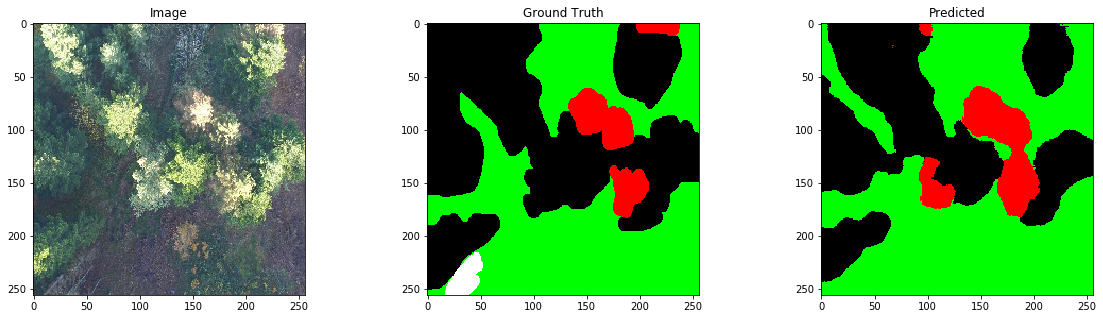

In [15]:
sample_image, sample_mask = set_sample_image('DJI_0219.JPG','DJI_0219.png')
pred = show_predictions()

Text(0.5, 1.0, 'dead')

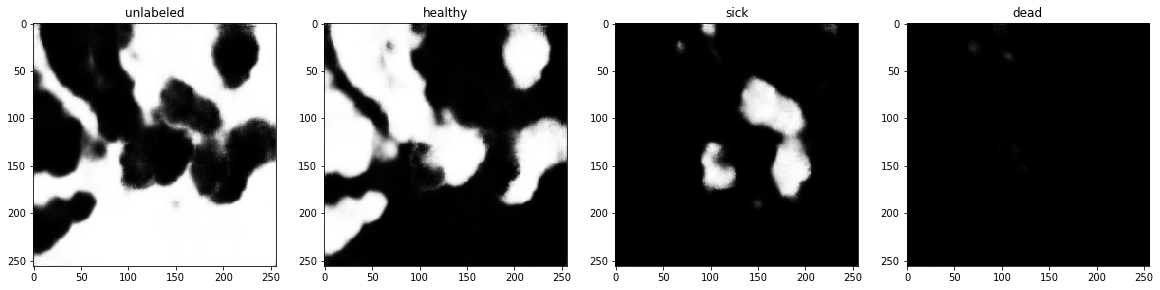

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

plt.subplot(1, 4, 1)
plt.imshow(pred[0, :,:, 0], vmin=0, vmax=1, cmap='gray')
plt.title('unlabeled')

plt.subplot(1, 4, 2)
plt.imshow(pred[0, :,:, 1], vmin=0, vmax=1, cmap='gray')
plt.title('healthy')

plt.subplot(1, 4, 3)
plt.imshow(pred[0, :,:, 2], vmin=0, vmax=1, cmap='gray')
plt.title('sick')

plt.subplot(1,4,4)
plt.imshow(pred[0, :,:, 3], vmin=0, vmax=1, cmap='gray')
plt.title('dead')